In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import sys
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV, train_test_split, cross_val_score, ShuffleSplit, KFold
from sklearn import metrics
import seaborn as sns
import pickle
pd.options.display.float_format = '{:,.3f}'.format

import matplotlib
font = {'family' : 'Arial', 'size'   : 12}
matplotlib.rc('font', **font)

In [2]:
def get_samples(vectors):
    if vectors == 'pfam-dst':
        return pd.read_csv('../data/training/positive/mibig_bgcs_all.{}.csv'.format(vectors)).set_index('contig_id')
    return pd.read_pickle("../data/training/positive/mibig_bgcs_all.{}.pkl".format(vectors))

In [3]:
def get_sample_responses(vectors, responses):
    samples = get_samples(vectors)
    responses = responses.loc[samples.index].dropna()
    samples = samples.loc[responses.index]
    return samples, responses

# Candidate classification: Multilabel and multiclass method evaluation

## Problem specification

Predict biosynthetic classes of BGC candidates.

### Multilabel approach

Assign a set of classes (labels) to each BGC candidate

Model output is a binary vector:

In [4]:
labels = pd.read_csv("../data/training/positive/mibig_bgcs_all.classes.csv").set_index('contig_id')
labels = labels[~labels['?'].astype(np.bool)]
del labels['?']
del labels['Nucleoside']
labels.sample(5)

,Alkaloid,NRP,Other,Polyketide,RiPP,Saccharide,Terpene
contig_id,,,,,,,
BGC0000576.1,0,0,0,0,1,0,0
BGC0000534.1,0,0,0,0,1,0,0
BGC0000175.1,0,0,0,1,0,0,0
BGC0000299.1,0,1,0,0,0,0,0
BGC0001343.1,0,0,0,1,0,0,0


## Input data

### Domain set

Binary vector of all pfam IDs found in MIBiG dataset, 1 = pfam is present in sequence, 0 = pfam is not present

In [5]:
get_samples('domain_set').head(3)

pfam_id,PF00004,PF00005,PF00006,PF00009,PF00010,PF00011,PF00012,PF00013,PF00015,PF00022,...,PF17387,PF17389,PF17390,PF17391,PF17392,PF17414,PF17425,PF17508,PF17584,PF17608
contig_id,,,,,,,,,,,,,,,,,,,,,
BGC0000001.1,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
BGC0000002.1,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
BGC0000003.1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [6]:
all_ml_samples, all_ml_responses = get_sample_responses('domain_set', labels)

# AntiSMASH classification

In [7]:
antismash = pd.read_csv('../data/mibig/antismash/classification.csv')
antismash.head()

,contig_id,nucl_start,nucl_end,candidate_id,classes,detection_rules,genes,subclusters,NRPSs/PKSs,signature_genes,RiPPs,predicted_structure,monomers
0,BGC0000001.1,0,59320,BGC0000001.1:0-59320,t1pks,t1pks: ((PKS_KS &amp; PKS_AT) or (ene_KS &amp;...,AEK75490.1;AEK75491.1;AEK75492.1;AEK75493.1;AE...,nan,NaN,AEK75493;AEK75497;AEK75499;AEK75502;AEK75503;A...,-,nan,NaN
1,BGC0000002.1,0,141542,BGC0000002.1:0-141542,oligosaccharide;t1pks,"oligosaccharide: (minimum(3,[Glycos_transf_1,G...",AHH99917.1;AHH99918.1;AHH99919.1;AHH99920.1;AH...,nan,NaN,AHH99918;AHH99919;AHH99920;AHH99921;AHH99922;A...,-,nan,NaN
2,BGC0000003.1,0,37168,BGC0000003.1:0-37168,t1pks,t1pks: ((PKS_KS &amp; PKS_AT) or (ene_KS &amp;...,BAD97694.1;BAD97695.1;BAD97696.1;BAD97697.1;BA...,nan,BAD97694;BAD97699,BAD97694;BAD97696;BAD97699,-,nan,(pk)
3,BGC0000004.1,0,45060,BGC0000004.1:0-45060,t1pks,t1pks: ((PKS_KS &amp; PKS_AT) or (ene_KS &amp;...,BAE71313.1;BAE71314.1;BAE71315.1;BAE71316.1;BA...,nan,BAE71314;BAE71315;BAE71316;BAE71317,BAE71314;BAE71315;BAE71316;BAE71317,-,nan,(pk) + (mal)
4,BGC0000006.1,0,43732,BGC0000006.1:0-43732,t1pks,t1pks: ((PKS_KS &amp; PKS_AT) or (ene_KS &amp;...,AAS90092.1;AAS90093.1;AAS90110.1;AAS90111.1;AA...,nan,AAS90093;AAS90110;AAS90111;AAS90095,AAS90093;AAS90110;AAS90111;AAS90095,-,nan,(pk) + (mal)


In [8]:
# Alkaloid, NRP, Other, Polyketide, RiPP, Saccharide, Terpene

AS_SUPERCLASSES = {
    'nrps': 'NRP',
    't1pks': 'Polyketide',
    't2pks': 'Polyketide',
    'terpene': 'Terpene',
    'lantipeptide': 'RiPP',
    'otherks': 'Polyketide',
    'transatpks': 'Polyketide',
    'indole': 'Alkaloid',
    'bacteriocin': 'RiPP',
    'amglyccycl': 'Saccharide',
    't3pks': 'Polyketide',
    'other': 'Other',
    'thiopeptide': 'RiPP',
    'oligosaccharide': 'Saccharide',
    'lassopeptide': 'RiPP',
    'nucleoside': 'Other',
    'cyanobactin': 'RiPP',
    'siderophore': None, # can be NRP and non-NRP (Other)
    'arylpolyene': 'Polyketide',
    'melanin': 'Other',
    'butyrolactone': 'Other',
    'blactam': None, # can be NRP and non-NRP (Other)
    'ectoine': 'Other',
    'ladderane': None, # not in JSON 
    'aminocoumarin': 'Other',
    'phenazine': 'Other',
    'PUFA': 'Polyketide',
    'phosphonate': 'Other',
    'sactipeptide': 'RiPP',
    'linaridin': 'RiPP',
    'bottromycin': 'RiPP',
    'microviridin': 'RiPP',
    'furan': 'Polyketide',
    'hserlactone': None, # can be NRP, but is not a subclass
    'head_to_tail': 'RiPP', 
    'glycocin': 'RiPP',
    'proteusin': 'RiPP',
    'microcin': 'RiPP',
    'pbde': 'Other',
    'phosphoglycolipid': 'Other',
    'fused': None, # not in JSON
    'ppysks': 'Other',
    'resorcinol': 'Other'
}

In [9]:
as_classes_sublists = antismash.groupby('contig_id')['classes'].apply(lambda lists: [c for classes in lists for c in classes.split(';')])
as_classes_sublists.head()

contig_id
BGC0000001.1                     [t1pks]
BGC0000002.1    [oligosaccharide, t1pks]
BGC0000003.1                     [t1pks]
BGC0000004.1                     [t1pks]
BGC0000006.1                     [t1pks]
Name: classes, dtype: object

In [10]:
as_superclasses_sublists = as_classes_sublists.apply(lambda classes: [AS_SUPERCLASSES[c] for c in classes])
as_superclasses_sublists[:10]

contig_id
BGC0000001.1                [Polyketide]
BGC0000002.1    [Saccharide, Polyketide]
BGC0000003.1                [Polyketide]
BGC0000004.1                [Polyketide]
BGC0000006.1                [Polyketide]
BGC0000007.1                [Polyketide]
BGC0000008.1                [Polyketide]
BGC0000009.1                [Polyketide]
BGC0000011.1                [Polyketide]
BGC0000012.1                [Polyketide]
Name: classes, dtype: object

In [11]:
ambiguous_bgcs = as_superclasses_sublists[as_superclasses_sublists.apply(lambda classes: any(c is None for c in classes))]
print('BGCs with unknown superclass:', len(ambiguous_bgcs))
ambiguous_bgcs

BGCs with unknown superclass: 34


contig_id
BGC0000182.1           [None, Polyketide, Polyketide]
BGC0000213.1                       [Polyketide, None]
BGC0000283.1                       [Saccharide, None]
BGC0000288.1                              [None, NRP]
BGC0000295.1                                   [None]
BGC0000299.1                              [None, NRP]
BGC0000314.1                              [None, NRP]
BGC0000329.1                              [None, NRP]
BGC0000429.1                  [NRP, Polyketide, None]
BGC0000841.1                                   [None]
BGC0000842.1                                   [None]
BGC0000843.1                                   [None]
BGC0000845.1                                   [None]
BGC0000846.1                                   [None]
BGC0000847.1                                   [None]
BGC0000939.1                                   [None]
BGC0000940.1                                   [None]
BGC0000941.1                                   [None]
BGC0000942.1      

In [12]:
selected_bgc_ids = np.setdiff1d(all_ml_samples.index.values, ambiguous_bgcs.index.values)
len(selected_bgc_ids)

1501

In [13]:
# Filter samples and responses by selected BGC IDs
ml_samples = all_ml_samples.loc[selected_bgc_ids]
ml_responses = all_ml_responses.loc[selected_bgc_ids]

In [14]:
# Convert to binary lists
as_responses_list = list(as_superclasses_sublists.apply(lambda classes: [int(c in classes) for c in ml_responses.columns]))
# Create dataframe with columns = classes, rows = bgcs
as_responses = pd.DataFrame(as_responses_list, index=as_superclasses_sublists.index, columns=ml_responses.columns)
# Select BGCs based on IDs in ml_responses
as_responses = as_responses.reindex(ml_responses.index).fillna(0)
print(as_responses.shape)
as_responses.head()

(1501, 7)


,Alkaloid,NRP,Other,Polyketide,RiPP,Saccharide,Terpene
contig_id,,,,,,,
BGC0000001.1,0.000,0.000,0.000,1.000,0.000,0.000,0.000
BGC0000002.1,0.000,0.000,0.000,1.000,0.000,1.000,0.000
BGC0000003.1,0.000,0.000,0.000,1.000,0.000,0.000,0.000
BGC0000004.1,0.000,0.000,0.000,1.000,0.000,0.000,0.000
BGC0000005.1,0.000,0.000,0.000,0.000,0.000,0.000,0.000


In [15]:
as_no_classes = as_responses[as_responses.sum(axis=1) == 0]
print('AntiSMASH predicted no class for {} BGCs'.format(len(as_no_classes)))
as_no_classes.index

AntiSMASH predicted no class for 356 BGCs


Index(['BGC0000005.1', 'BGC0000010.1', 'BGC0000015.2', 'BGC0000016.1',
       'BGC0000019.1', 'BGC0000025.1', 'BGC0000088.1', 'BGC0000095.1',
       'BGC0000095.11', 'BGC0000095.14',
       ...
       'BGC0001398.7', 'BGC0001398.8', 'BGC0001401.1', 'BGC0001401.2',
       'BGC0001401.3', 'BGC0001401.4', 'BGC0001401.5', 'BGC0001410.1',
       'BGC0001411.1', 'BGC0001412.1'],
      dtype='object', name='contig_id', length=356)

In [16]:
print('Classes of BGCs not predicted by AntiSMASH:')
ml_responses.loc[as_no_classes.index].sum()

Classes of BGCs not predicted by AntiSMASH:


Alkaloid      11.000
NRP           26.000
Other         63.000
Polyketide   103.000
RiPP          40.000
Saccharide    98.000
Terpene       40.000
dtype: float64

In [17]:
as_scores = pd.DataFrame({
    'AUC': metrics.roc_auc_score(ml_responses, as_responses, average=None), 
    'Precision': metrics.precision_score(ml_responses, as_responses, average=None), 
    'Recall': metrics.recall_score(ml_responses, as_responses, average=None)
}, index=ml_responses.columns)
as_scores

,AUC,Precision,Recall
Alkaloid,0.785,0.434,0.590
NRP,0.915,0.939,0.852
Other,0.671,0.594,0.370
Polyketide,0.870,0.901,0.806
RiPP,0.897,0.958,0.799
Saccharide,0.607,0.769,0.223
Terpene,0.744,0.908,0.492


In [18]:
as_scores.mean()

AUC         0.784
Precision   0.786
Recall      0.590
dtype: float64

# Random Forest: Multilabel classification results

### Shuffle split

In [19]:
def create_model():
    return RandomForestClassifier(n_estimators=100, random_state=0)

In [20]:
major_bgc_ids = pd.Series(selected_bgc_ids).apply(lambda contig_id: contig_id.split('.')[0])
major_bgc_ids.head()

0    BGC0000001
1    BGC0000002
2    BGC0000003
3    BGC0000004
4    BGC0000005
dtype: object

In [21]:
major_to_minor_ids = pd.Series(selected_bgc_ids, index=major_bgc_ids)
major_to_minor_ids.head()

BGC0000001    BGC0000001.1
BGC0000002    BGC0000002.1
BGC0000003    BGC0000003.1
BGC0000004    BGC0000004.1
BGC0000005    BGC0000005.1
dtype: object

In [22]:
unique_major_ids = major_bgc_ids.unique()
len(unique_major_ids)

1355

In [23]:
splitter = KFold(n_splits=5, shuffle=True, random_state=0)

scores = []
accuracies = []
mc_y_test = []
mc_pred = []
for id_train_idx, id_test_idx in splitter.split(unique_major_ids):
    train_major_ids, test_major_ids = unique_major_ids[id_train_idx], unique_major_ids[id_test_idx]
    train_minor_ids, test_minor_ids = major_to_minor_ids.loc[train_major_ids], major_to_minor_ids.loc[test_major_ids]
    X_train, X_test = ml_samples.loc[train_minor_ids].values, ml_samples.loc[test_minor_ids].values
    y_train, y_test = ml_responses.loc[train_minor_ids].values, ml_responses.loc[test_minor_ids].values
    print('Train:', len(X_train), 'Test:', len(X_test))
    split_model = create_model()
    # fitting the model
    split_model.fit(X_train, y_train)
    # predict the response
    pred = split_model.predict(X_test)
    mc_y_test += [';'.join(ml_responses.columns[resp.astype(np.bool)]) for resp in y_test]
    mc_pred += [';'.join(ml_responses.columns[resp.astype(np.bool)]) for resp in pred]
    aucs = metrics.roc_auc_score(y_test, pred, average=None)
    precisions = metrics.precision_score(y_test, pred, average=None)
    recalls = metrics.recall_score(y_test, pred, average=None)
    accuracy = metrics.accuracy_score(y_test, pred)
    accuracies.append(accuracy)
    scores += [{'Precision': p, 'Recall': r, 'AUC': a, 'Class': c} for p,r,a,c in zip(precisions, recalls, aucs, ml_responses.columns)]
    
scores = pd.DataFrame(scores).groupby('Class').mean()

print('Accuracy (exact match)', np.mean(accuracies))
print(scores.mean())
scores


Train: 1199 Test: 302
Train: 1194 Test: 307
Train: 1220 Test: 281
Train: 1192 Test: 309
Train: 1199 Test: 302
Accuracy (exact match) 0.6934747298208637
AUC         0.792
Precision   0.871
Recall      0.607
dtype: float64


,AUC,Precision,Recall
Class,,,
Alkaloid,0.607,0.733,0.216
NRP,0.907,0.904,0.850
Other,0.583,0.876,0.171
Polyketide,0.903,0.876,0.898
RiPP,0.907,0.935,0.823
Saccharide,0.811,0.906,0.631
Terpene,0.824,0.867,0.658


In [24]:
merged_scores = pd.concat([scores, as_scores[scores.columns]], axis=1)
merged_scores.columns = pd.MultiIndex.from_product([['RandomForest','AntiSMASH'], scores.columns.values])
merged_scores.insert(0, ('', '# samples'), ml_responses.sum().astype(np.int))
merged_scores = merged_scores.sort_values(by=('', '# samples'), ascending=False)
merged_scores = merged_scores.append(pd.Series(merged_scores.mean(), name='Average'))
merged_scores

RandomForest                  AntiSMASH                 
           # samples          AUC Precision Recall       AUC Precision Recall
Class                                                                        
Polyketide   644.000        0.903     0.876  0.898     0.870     0.901  0.806
NRP          433.000        0.907     0.904  0.850     0.915     0.939  0.852
RiPP         199.000        0.907     0.935  0.823     0.897     0.958  0.799
Saccharide   179.000        0.811     0.906  0.631     0.607     0.769  0.223
Other        154.000        0.583     0.876  0.171     0.671     0.594  0.370
Terpene      120.000        0.824     0.867  0.658     0.744     0.908  0.492
Alkaloid      39.000        0.607     0.733  0.216     0.785     0.434  0.590
Average      252.571        0.792     0.871  0.607     0.784     0.786  0.590

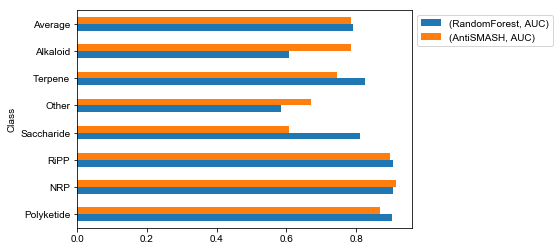

In [25]:
ax = merged_scores[[('RandomForest','AUC'),('AntiSMASH','AUC')]].plot.barh()
ax.legend(bbox_to_anchor=(1,1))

In [28]:
import itertools

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    return plt.gcf()

Confusion matrix, without normalization


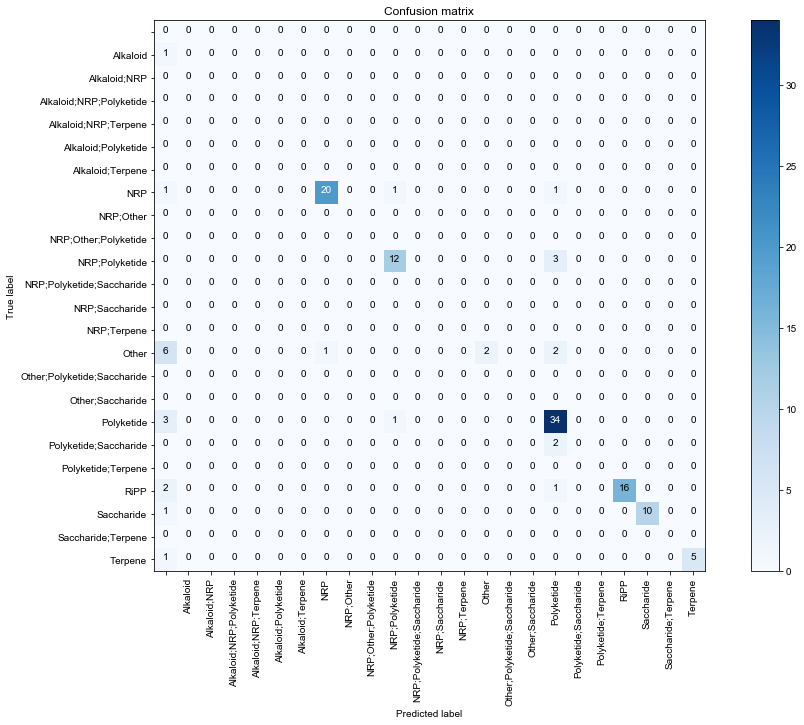

In [29]:
mc_all_labels = np.unique(np.concatenate([mc_y_test, mc_pred]))
matrix = metrics.confusion_matrix(mc_y_test, mc_pred, labels=mc_all_labels)
matrix = (matrix / 10).astype(np.int)
fig, ax = plt.subplots(1, 1, figsize=(14, 10))
fig = plot_confusion_matrix(matrix, mc_all_labels)

In [30]:
fig.savefig('../data/figures/paper/supplementary/S8.pdf', bbox_inches='tight')

# Final model training

In [32]:
model = RandomForestClassifier(n_estimators=100, random_state=0)
model.fit(all_ml_samples.values, all_ml_responses.values)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=1,
            oob_score=False, random_state=0, verbose=0, warm_start=False)

In [33]:
# TODO: save list of features (or feature transformer) along with model
#with open('../data/models/trained/class-domain_set-rf.pickle', 'wb') as f:
#    pickle.dump(model, f)

## Feature importance

In [34]:
def plot_importance(model, label='Global', **kwargs):
    importance = pd.DataFrame({'importance': model.feature_importances_, 'pfam_id': ml_samples.columns.values})
    importance = importance.set_index('pfam_id')['importance'].sort_values()
    ax = importance[-10:].plot.barh(**kwargs)
    ax.set_xlabel('{} feature importance'.format(label))

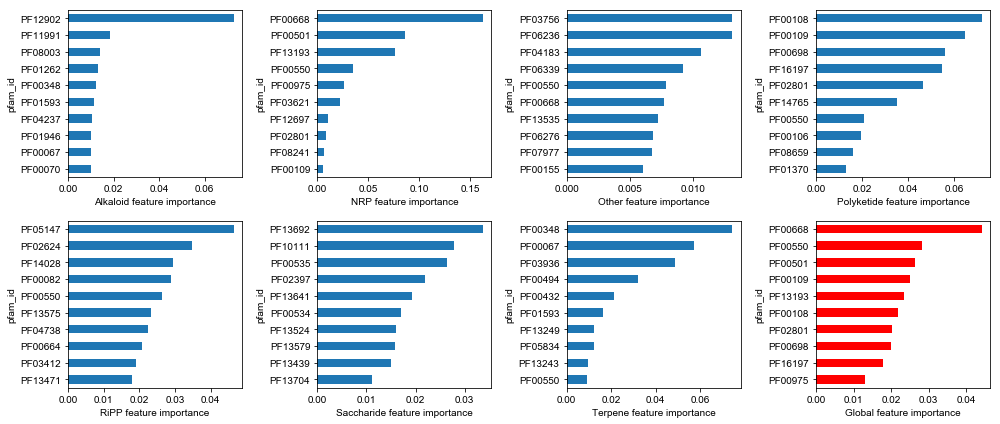

In [35]:
# Per-class feature importance

fig, axes = plt.subplots(2, 4, figsize=(14, 6))

for i, cls in enumerate(ml_responses.columns):
    class_model = RandomForestClassifier(n_estimators=100, random_state=0)
    class_model.fit(all_ml_samples.values, all_ml_responses[cls].values)
    plot_importance(class_model, label=cls, ax=axes[i // 4][i % 4])

plot_importance(model, ax=axes[-1][-1], color='red')
plt.tight_layout()
fig.savefig('../data/figures/paper/supplementary/S9.pdf', bbox_inches='tight')

# Candidate class prediction

In [73]:
def read_vectors_to_predict(path, train_columns):
    vectors = pd.read_pickle(path)
    for col in set(train_columns).difference(vectors.columns):
        vectors[col] = 0
    return vectors[train_columns.values]

In [74]:
model_path = '128lstm-100pfamdim-8pfamiter-posweighted-neg-10k-fpr2'

In [67]:
candidates = read_vectors_to_predict("../data/bacteria/candidates/{}/domain_set.pkl".format(model_path), ml_samples.columns)
candidates.head()

pfam_id,PF00004,PF00005,PF00006,PF00009,PF00010,PF00011,PF00012,PF00013,PF00015,PF00022,...,PF17387,PF17389,PF17390,PF17391,PF17392,PF17414,PF17425,PF17508,PF17584,PF17608
contig_id,,,,,,,,,,,,,,,,,,,,,
000749207dc6a8d25a7b67282a2fe375,0,0,0,0,0.000,0,0,0,0,0.000,...,0,0,0,0.000,0.000,0.000,0,0,0.000,0.000
00244b39ef89b1f18ccf4da018657383,0,0,0,0,0.000,0,0,0,0,0.000,...,0,0,0,0.000,0.000,0.000,0,0,0.000,0.000
0024a1c619f0dba6e8420c60b6c815e7,0,0,0,0,0.000,0,0,0,0,0.000,...,0,0,0,0.000,0.000,0.000,0,0,0.000,0.000
002d6748dad4145b1f09ca9dc93ead44,0,0,0,0,0.000,0,0,0,0,0.000,...,0,0,0,0.000,0.000,0.000,0,0,0.000,0.000
003041bd79286a337bdd94c332198c33,0,0,0,0,0.000,0,0,0,0,0.000,...,0,0,0,0.000,0.000,0.000,0,0,0.000,0.000


In [81]:
columns = ml_responses.columns
results = np.array([r[:,1] for r in model.predict_proba(candidates.values)]).transpose()
predictions = pd.DataFrame(results, index=candidates.index, columns=columns)
predictions['classes'] = [';'.join(columns[x >= 0.5]) for x in results]
predictions.head()

,Alkaloid,NRP,Other,Polyketide,RiPP,Saccharide,Terpene,classes
contig_id,,,,,,,,
000749207dc6a8d25a7b67282a2fe375,0.000,0.000,0.060,0.000,0.000,0.940,0.000,Saccharide
00244b39ef89b1f18ccf4da018657383,0.010,0.020,0.180,0.250,0.020,0.609,0.010,Saccharide
0024a1c619f0dba6e8420c60b6c815e7,0.000,0.920,0.020,0.030,0.030,0.000,0.000,NRP
002d6748dad4145b1f09ca9dc93ead44,0.000,0.040,0.050,0.076,0.044,0.780,0.010,Saccharide
003041bd79286a337bdd94c332198c33,0.010,0.000,0.030,0.070,0.010,0.870,0.010,Saccharide


In [82]:
predictions.to_csv('../data/bacteria/candidates/{}/classes/class-domain_set-rf/classes.csv'.format(model_path))